In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
from scipy.special import softmax


In [10]:
runs = [
    "rl-run2-dqn-2-data.json",
    # "rl-run-dqn-13-data.json",
    # "rl-run-dqn-7-data.json"
]

data = defaultdict(list)
for run in runs:
    with open(run, "r") as f:
        data_new = json.load(f)
        for map_name in data_new:
            data[map_name] = data[map_name]+data_new[map_name]

In [11]:
max_epsilon = 0
min_epsilon = np.inf
map_name = list(data.keys())[0]
for i in range(len(data[map_name])):
        epsilon = data[map_name][i]["info"]["epsilon"]
        max_epsilon = max(max_epsilon, epsilon)
        min_epsilon = min(min_epsilon, epsilon)

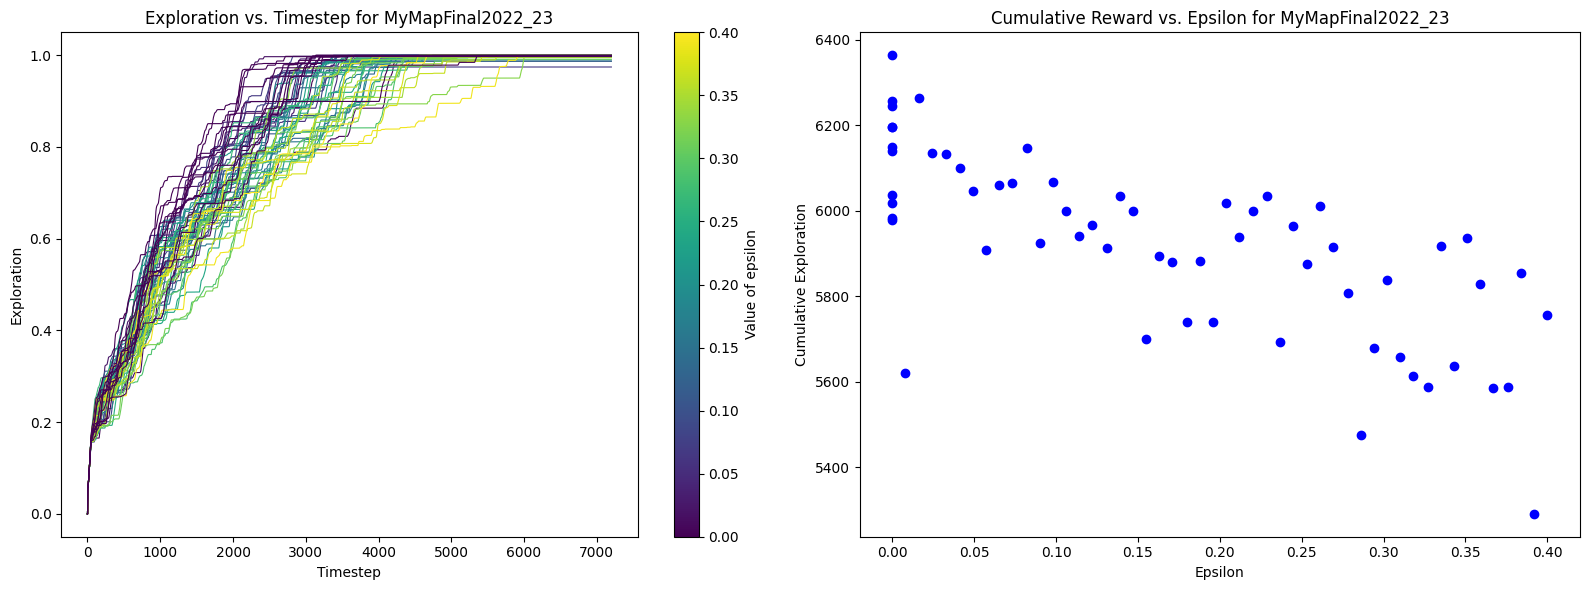

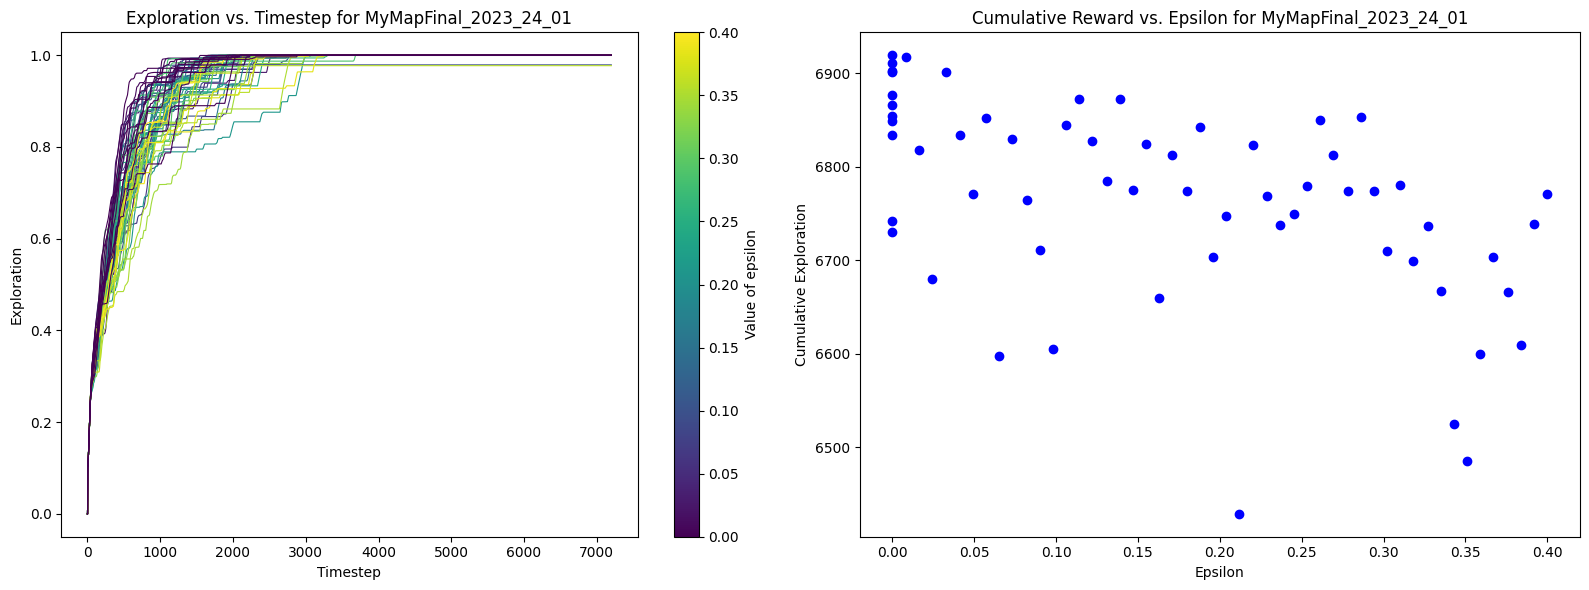

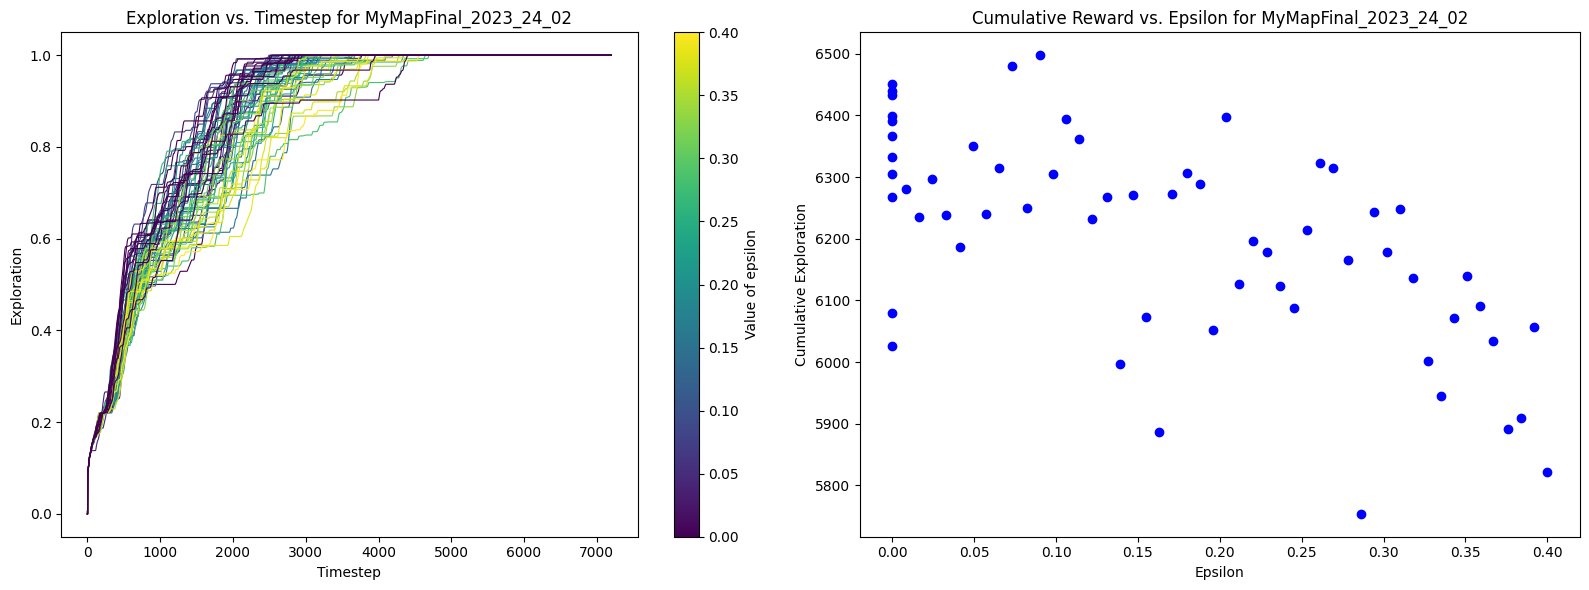

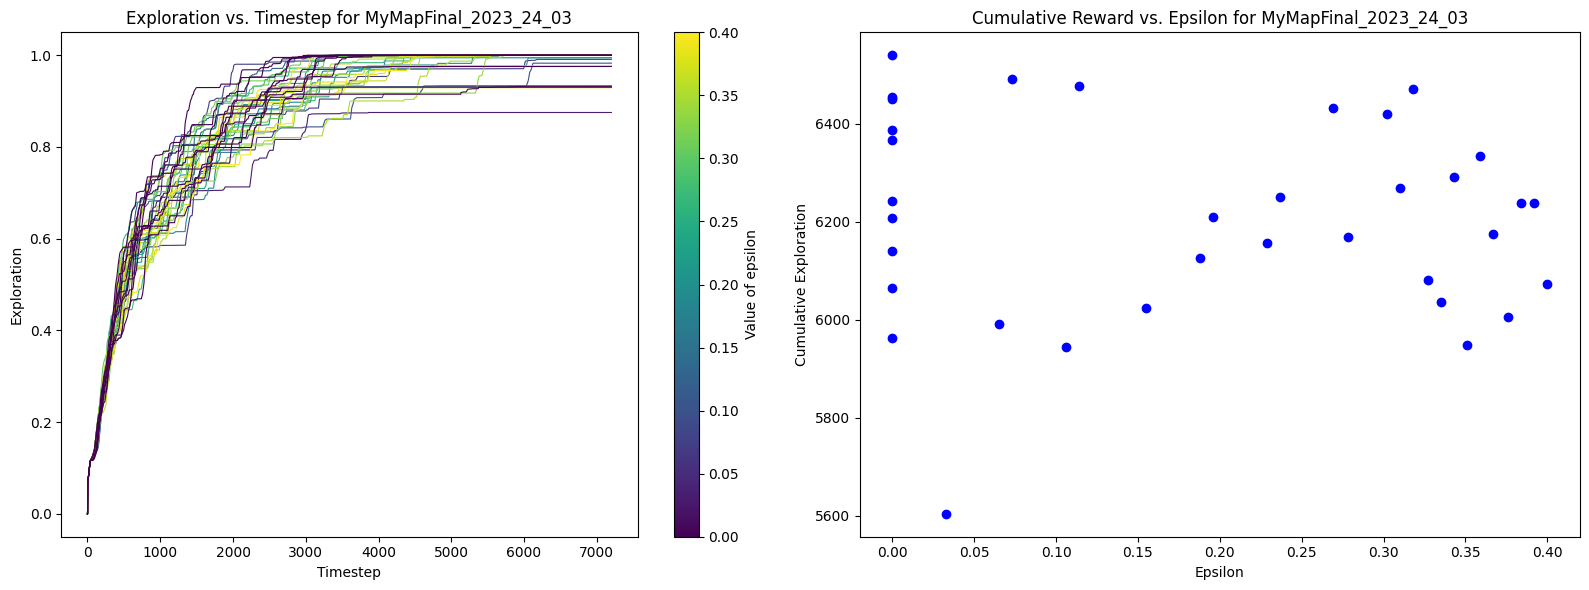

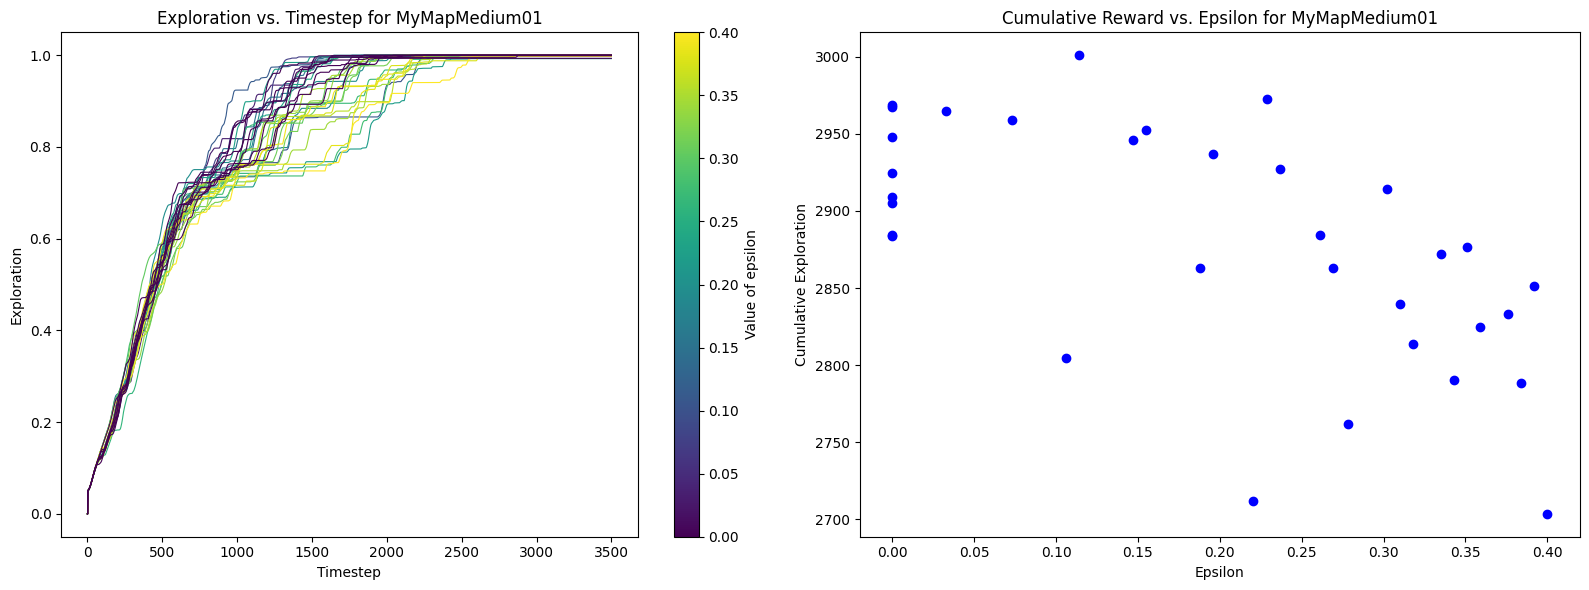

In [12]:
norm = plt.Normalize(min_epsilon, max_epsilon)
cm = plt.cm.viridis

for map_name in data:
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot the exploration in respect to timestep (Left plot)
    ax1.set_title(f"Exploration vs. Timestep for {map_name}")
    for i in range(len(data[map_name])):
        ax1.plot(
            data[map_name][i]["score"], 
            color=cm(norm(data[map_name][i]["info"]["epsilon"])), 
            linewidth=0.8
        )
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])  # Required for ScalarMappable
    fig.colorbar(sm, label="Value of epsilon", ax=ax1)
    ax1.set_xlabel("Timestep")
    ax1.set_ylabel("Exploration")
    
    # Plot the cumulative reward as a function of epsilon (Right plot)
    ax2.set_title(f"Cumulative Reward vs. Epsilon for {map_name}")
    cumulative_rewards = [sum(data[map_name][i]["score"]) for i in range(len(data[map_name]))]
    epsilons = [data[map_name][i]["info"]["epsilon"] for i in range(len(data[map_name]))]
    ax2.plot(epsilons, cumulative_rewards, marker="o", linestyle="None", color="blue", linewidth=1.5)
    ax2.set_xlabel("Epsilon")
    ax2.set_ylabel("Cumulative Exploration")
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [13]:
def get_rewards():
    rewards = defaultdict(list)
    for map_name in data:
        for i in range(len(data[map_name])):
            rewards[map_name].append(np.sum(data[map_name][i]["score"]))
    return rewards

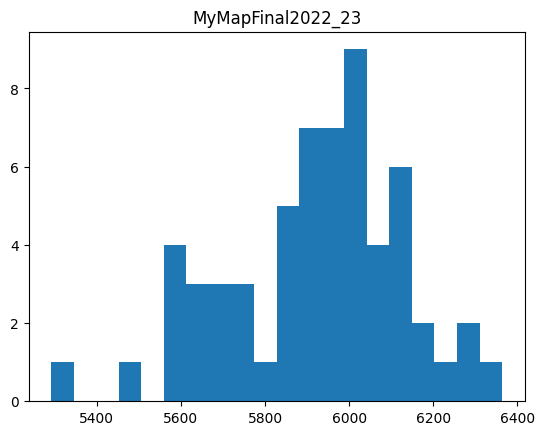

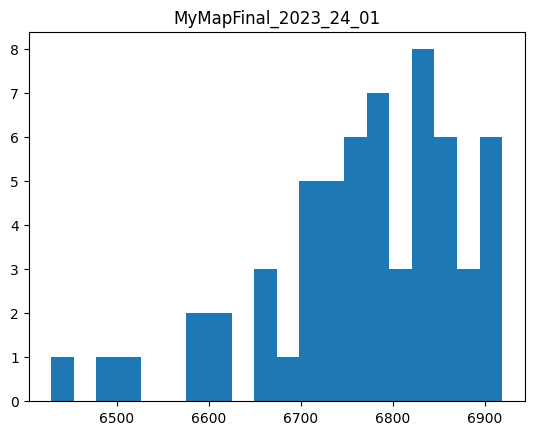

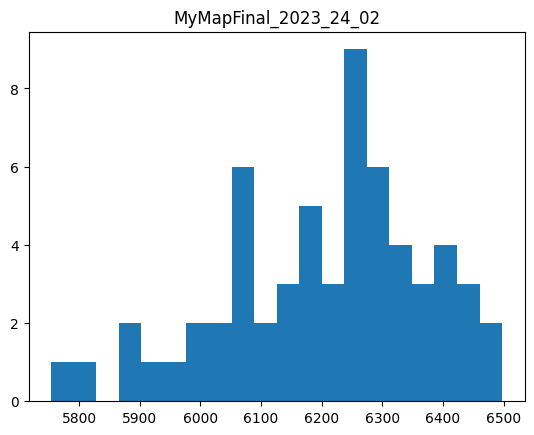

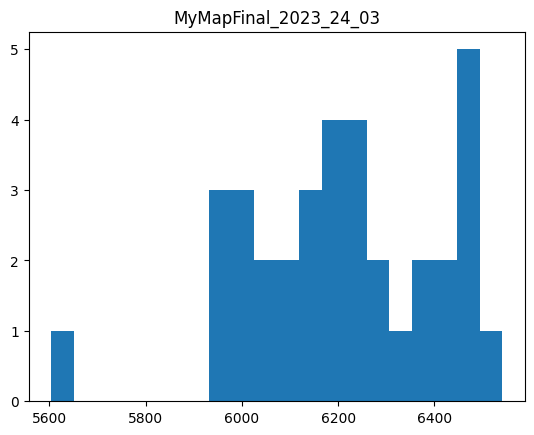

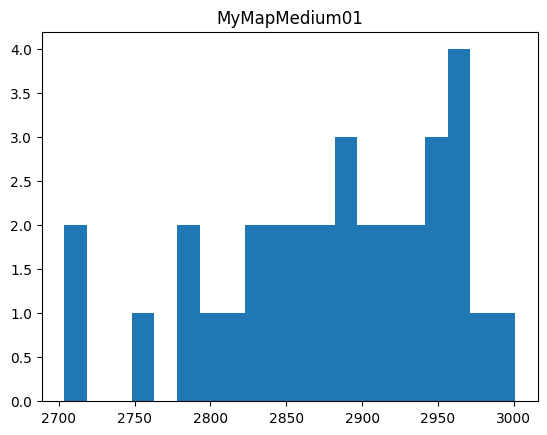

In [14]:
rewards = get_rewards()
for map_name in rewards:
    plt.figure()
    plt.title(map_name)
    plt.hist(rewards[map_name],bins=20)

plt.show()

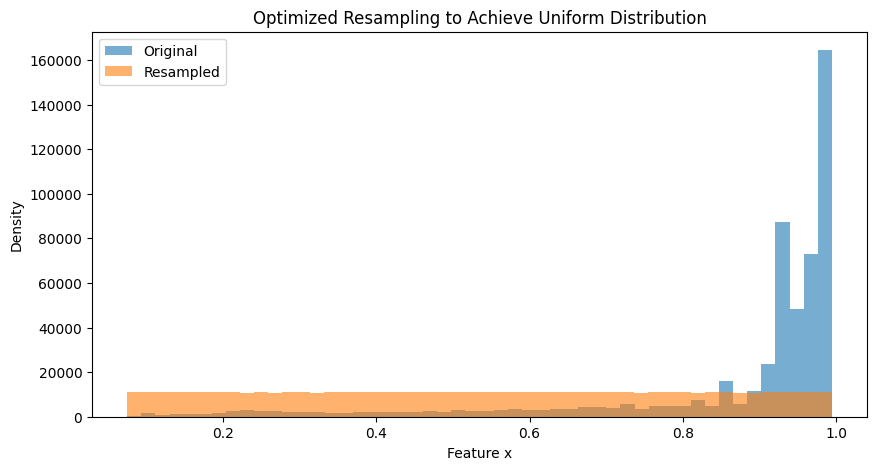

In [15]:
total_transitions = []
for map_name in data:
    for i in range(len(data[map_name])):
        transition = data[map_name][i]["run"]["obs"]
        for j in range(len(transition)):
            if transition[j][-3]>0.995:
                continue
            total_transitions.append(transition[j][-3])

x = np.array(total_transitions)

# Estimate density using histogram
num_bins = 50
hist, bin_edges = np.histogram(x, bins=num_bins, density=True)

# Assign weights based on bin frequencies
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Bin centers
bin_width = bin_edges[1] - bin_edges[0]
hist_density = hist / np.sum(hist * bin_width)  # Normalize density

# Map each point in x to its corresponding bin
bin_indices = np.digitize(x, bin_edges) - 1  # Bin indices for each x
bin_indices = np.clip(bin_indices, 0, num_bins - 1)  # Ensure indices are valid

# Compute weights inversely proportional to density
weights = 1 / hist_density[bin_indices]
weights /= weights.sum()  # Normalize weights

# Resample data based on weights
resampled_indices = np.random.choice(np.arange(len(x)), size=len(x), p=weights)
x_resampled = x[resampled_indices]

# Plot original and resampled distributions
plt.figure(figsize=(10, 5))
plt.hist(x, bins=50, alpha=0.6, label="Original")
plt.hist(x_resampled, bins=50, alpha=0.6, label="Resampled")
plt.title("Optimized Resampling to Achieve Uniform Distribution")
plt.legend()
plt.xlabel("Feature x")
plt.ylabel("Density")
plt.show()

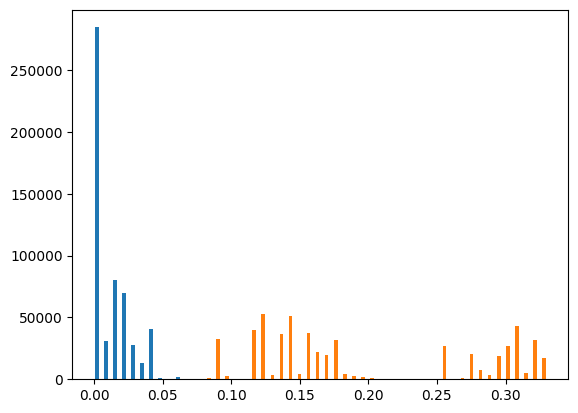

In [16]:
total_rew = []
for map_name in data:
    for i in range(len(data[map_name])):
        transition = data[map_name][i]["run"]["reward"]
        for j in range(len(transition)):
            total_rew.append(transition[1])

total_rew = np.array(total_rew)
plt.figure()
plt.hist(total_rew, bins=50)
plt.show()